In [52]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
import json
import tqdm
import re
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pandas.io.json import json_normalize
import pandas as pd
import pickle as pk

from nltk.tokenize import word_tokenize
import statistics
import seaborn as sns
from gensim.models import Word2Vec

# 导入所需的库
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [53]:
def get_data_path(data_dir):
    dirs = os.listdir(data_dir)

    for path in dirs:
        if "_train_" in path:
            train_path = os.path.join(data_dir,path)
        elif "_val_" in path:
            val_path = os.path.join(data_dir,path)
        elif "_test_" in path:
            test_path = os.path.join(data_dir,path)
    return train_path, val_path, test_path

In [54]:
def getDataJSON(route):
    with open(route,"r",encoding="utf-8") as f:
        result = [json.loads(line) for line in f.read().splitlines()]
    return result

In [55]:
def get_data(path, ngram_range=(1,2)):
    data = pd.DataFrame(getDataJSON(path))
    return data

In [56]:
data_dir = '/Users/bingru/Workspace/ML/IndividualProject/Data/darkreddit_authorship_attribution_anon'

train_path, val_path, test_path = get_data_path(data_dir)

In [57]:
train = get_data(train_path)
val = get_data(val_path)
test = get_data(test_path)

In [58]:
train

,author,comment
0,user1,"lol, I don't think you'd be fucking over DeafP..."
1,user1,"You know, I think you might be right. In fact..."
2,user1,"Yeah, my guess is that its overlooked somewher..."
3,user1,I'd be curious what drugs are actually cheaper...
4,user1,&gt; wtf is a partial ship?\n\nLMFAO! I was w...
...,...,...
6812,user10,"Incidentally, this is a historic occasion: Tom..."
6813,user10,"If you're buying, you're buying. A lot of peop..."
6814,user10,But he also ran an insecure market which delib...
6815,user10,We heard about the confiscation a week or two ...


In [59]:
data =pd.concat([train, val, test], axis=0)

In [60]:
data

,author,comment
0,user1,"lol, I don't think you'd be fucking over DeafP..."
1,user1,"You know, I think you might be right. In fact..."
2,user1,"Yeah, my guess is that its overlooked somewher..."
3,user1,I'd be curious what drugs are actually cheaper...
4,user1,&gt; wtf is a partial ship?\n\nLMFAO! I was w...
...,...,...
2271,user10,"No, the feds are not so kind as to give public..."
2272,user10,"Of course it struck me as odd, and I deliberat..."
2273,user10,"&gt; You had me until this post, and then you ..."
2274,user10,"Wait, am I reading this correctly?\n\n&gt; Ins..."


In [61]:
# Define acronym substitution table
abbreviation_dict = {
    "u": "you",
    "r": "are",
    "y": "why",
    "b": "be",
    "c": "see",
    "w": "with",
    "hru": "how are you",
    "luv": "love",
    "gr8": "great",
    "2": "to",
    "4": "for",
    "b4": "before",
    "bc": "because",
    "cuz": "because",
    "thx": "thanks",
    "plz": "please",
    "pls": "please",
    "sry": "sorry",
    "fam": "family",
    "bro": "brother",
    "sis": "sister",
    "gf": "girlfriend",
    "bf": "boyfriend",
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "you're": "you are",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
}

# 定义口语化词汇替换表
colloquial_dict = {
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "hafta": "have to",
    "kinda": "kind of",
    "sorta": "sort of",
    "lemme": "let me",
    "gimme": "give me",
    "getcha": "get you",
    "gotcha": "got you",
    "don't": "do not",
    "didn't": "did not",
    "doesn't": "does not",
    "aren't": "are not",
    "isn't": "is not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "can't": "cannot",
    "won't": "will not",
    "mightn't": "might not",
    "mustn't": "must not",
    "shoulda": "should have",
    "woulda": "would have",
    "coulda": "could have",
    "mighta": "might have",
    "musta": "must have",
}

In [62]:
slangs = ['omg', 'wtf', 'lol', 'gt', 'URL']
adjectives = ['good', 'bad', 'happy', 'sad', 'nice']
adverbs = ['very', 'really', 'so', 'just']
profanities = ['fuck', 'shit']

In [64]:
from nltk import WordNetLemmatizer
X = []

deleteWord = slangs + adjectives + adverbs + profanities
colloquial_dict.update(abbreviation_dict)

for text in tqdm.tqdm(data['comment'], desc="Processing train data "):
    text = text.lower()
    for k, v in colloquial_dict.items():
        text = re.sub(r'\b' + k + r'\b', v, text)
    text = re.sub(r'http\S+', ' URL ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[@$%^&*()]', '', text)
    pattern = '|'.join([re.escape(s) for s in deleteWord])
    cleaned_text = re.sub(pattern, '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    X.append(cleaned_text)

Processing train data : 100%|██████████| 11368/11368 [00:11<00:00, 978.61it/s] 


In [65]:
# pos
# Delete verbs Adverbs Adjectives
X_pre_remove = []
from nltk.stem import PorterStemmer
porter = PorterStemmer()
for text in tqdm.tqdm(X, desc="Delete adj, vb, and adv: "):
    t = nltk.word_tokenize(text)
    t = nltk.pos_tag(t)
    tag = []
    for i in t:
        # , "JJS", "RBR", "RBS", "VB", "VBN", "VBG", "CD", "VBP"
        if str(i[1]) not in ["JJ", "RB", "JJR"]:
            tag.append(i[0])
    text = " ".join(tag)
    X_pre_remove.append(text)

Delete adj, vb, and adv: 100%|██████████| 11368/11368 [00:35<00:00, 319.88it/s]


In [66]:
print(X_pre_remove[3])

I would be what drugs are on the darknet than buying from the pharmacy witho insurance painkillers are on the darknet me others are like bought from canada or me i bull on me of hte stats they said half the drugs bought are think it depends on where you buy them if you buy from an pharmacy they will be or from vendors who buy from these offshore pharmas but that is to lump that besee if you order from them youve got to realize you are getting grade drugs there was a cancer drug that was counterfeited and ld to legitimate pharmas and hospitals this is on the dnms in my mind they need to use a stat of counterfeits that imitate a medication like the pill shape color stamps etc I have been thinking of doing spot checking on my orders which are and sending to those labs that will test the pill if this would interest anyone i could post the results but how it would be to the community since my drug range is and order from a vendors at the I am going to do it for my ease besee I am by nature 

In [67]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')  # 将文本向量化
X = vectorizer.fit_transform(X_pre_remove).toarray()  # 将文本转换为 TF-IDF 特征向量

In [72]:
NMFmodel = NMF(
    n_components=10,  # topics
    max_iter=1000,
    init='nndsvd',
    random_state=0,
)

In [73]:
NMFmodel.fit(X)

NMF(init='nndsvd', max_iter=1000, n_components=10, random_state=0)

In [74]:
n_top_words = 15
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(NMFmodel.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
people use lot want markets think make meone things eone going drugs sub help using

Topic #1:
thread questions sunday threads opened link question rules thanks posted understanding information urces inquiries removed

Topic #2:
bitcoin wallet market escrow coins money agora use btc deposit cash address wallets bitcoins coinbase

Topic #3:
vendor vendors order fe product feedback customers escrow reviews customer shipping orders stealth review buyers

Topic #4:
mail package address tracking box drugs packages pack house order priority po sent office cd

Topic #5:
account reddit shadowbanned admins tor spam contact make approved site accounts posts comments means rean

Topic #6:
meth drugs mdma drug like sell weed buy darknet customers smoke cut gram lsd selling

Topic #7:
like did know time think mething got going said does yeah way say guess thing

Topic #8:
rules read subreddit advertising ban questions sidebar threads allow guidelines submission message banned posts ads

T

In [75]:
def vectorize_text(text_data):
    vectorizer = CountVectorizer(stop_words='english')
    vectorized = vectorizer.fit_transform(text_data)
    return vectorized, vectorizer

In [76]:
def run_nmf(text_data, n_topics):
    vectorized, vectorizer = vectorize_text(text_data)
    NMFmodel = NMF(
    n_components=n_topics,  # 主题数量
    max_iter=100,
    init='nndsvd',
    random_state=0,
    )
    NMFmodel.fit_transform(vectorized)
    topic_words = vectorizer.get_feature_names_out()
    topic_keywords = []
    for topic_weights in NMFmodel.components_:
        top_keyword_locs = (-topic_weights).argsort()[:8]
        topic_keywords.append([topic_words[i] for i in top_keyword_locs])
    doc_topics = NMFmodel.transform(vectorized)
    clusters = np.argmax(doc_topics, axis=1)
    return clusters

In [77]:
data['clusters'] = run_nmf(X_pre_remove,5)
print(data['clusters'])

0       0
1       0
2       2
3       0
4       2
       ..
2271    4
2272    0
2273    0
2274    4
2275    0
Name: clusters, Length: 11368, dtype: int64


In [78]:
df_0 = data[data['clusters']==0]
df_1 = data[data['clusters']==1]
df_2 = data[data['clusters']==2]
df_3 = data[data['clusters']==3]
df_4 = data[data['clusters']==4]

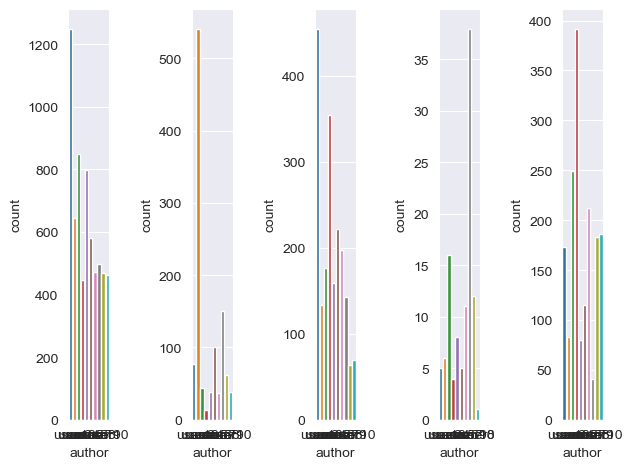

In [79]:
fig, ax = plt.subplots(1,5)
ax0 = sns.countplot(x="author", data=df_0, ax=ax[0])
ax1 = sns.countplot(x="author", data=df_1, ax=ax[1])
ax2 = sns.countplot(x="author", data=df_2, ax=ax[2])
ax3 = sns.countplot(x="author", data=df_3, ax=ax[3])
ax4 = sns.countplot(x="author", data=df_4, ax=ax[4])
plt.tight_layout()

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def train_test(df):
    vectorizer = CountVectorizer(ngram_range=(1, 5), max_features=10000)
    X = vectorizer.fit_transform(df['comment'])
    y = np.asarray(df['author'])
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2, # keep 20% for testing
                                                        random_state=2 # pass an int for reproducible rtesult
                                                        )

    svm = LinearSVC(max_iter=100000)
    svm.fit(X_train, y_train)

    # 测试
    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    return acc

In [81]:
df_list =[df_0, df_1, df_2, df_3,df_4]
accs = []
for df in df_list:
    acc = train_test(df)
    accs.append(acc)

              precision    recall  f1-score   support

       user1       0.83      0.87      0.85       235
      user10       0.69      0.65      0.67        81
       user2       0.87      0.84      0.85       130
       user3       0.68      0.77      0.72       180
       user4       0.87      0.75      0.81        89
       user5       0.69      0.68      0.68       182
       user6       0.61      0.63      0.62       104
       user7       0.89      0.79      0.84        96
       user8       0.69      0.64      0.66       103
       user9       0.70      0.73      0.72        94

    accuracy                           0.75      1294
   macro avg       0.75      0.74      0.74      1294
weighted avg       0.75      0.75      0.75      1294



/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       user1       0.30      0.38      0.33         8
      user10       0.56      0.50      0.53        10
       user2       0.82      0.93      0.87       101
       user3       0.50      0.20      0.29        10
       user4       0.00      0.00      0.00         7
       user5       0.43      0.50      0.46         6
       user6       0.64      0.52      0.57        27
       user7       1.00      0.50      0.67         8
       user8       0.73      0.75      0.74        32
       user9       0.39      0.58      0.47        12

    accuracy                           0.71       221
   macro avg       0.54      0.49      0.49       221
weighted avg       0.69      0.71      0.69       221

              precision    recall  f1-score   support

       user1       0.80      0.83      0.82        96
      user10       0.42      0.42      0.42        12
       user2       0.77      0.63      0.69        27
       user3       0.60 

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       user1       0.59      0.53      0.56        32
      user10       0.54      0.56      0.55        34
       user2       0.50      0.35      0.41        17
       user3       0.60      0.73      0.65        51
       user4       0.80      0.94      0.86        80
       user5       0.67      0.44      0.53        18
       user6       0.40      0.44      0.42        18
       user7       0.87      0.80      0.83        50
       user8       0.50      0.07      0.12        14
       user9       0.55      0.59      0.57        29

    accuracy                           0.66       343
   macro avg       0.60      0.55      0.55       343
weighted avg       0.66      0.66      0.65       343



In [82]:
print(np.mean(accs))

0.6408776573420469


In [83]:
acc_all = train_test(data)
print(acc_all)

              precision    recall  f1-score   support

       user1       0.81      0.84      0.83       381
      user10       0.72      0.75      0.74       155
       user2       0.89      0.87      0.88       293
       user3       0.73      0.73      0.73       263
       user4       0.91      0.88      0.89       257
       user5       0.64      0.64      0.64       204
       user6       0.69      0.74      0.71       197
       user7       0.91      0.83      0.87       185
       user8       0.71      0.67      0.69       185
       user9       0.66      0.70      0.68       154

    accuracy                           0.78      2274
   macro avg       0.77      0.76      0.76      2274
weighted avg       0.78      0.78      0.78      2274

0.7774846086191732
